[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0749 - val_loss: 3.0013e-04
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0033 - val_loss: 2.6559e-04
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0026 - val_loss: 2.5834e-04
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0021 - val_loss: 2.5743e-04
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0019 - val_loss: 3.9939e-04
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0019 - val_loss: 3.2250e-04
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0017 - val_loss: 2.5530e-04
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0015 - val_loss: 2.3410e-04
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0015 - val_loss: 5.0390e-04
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0015 - val_loss: 5.2250e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


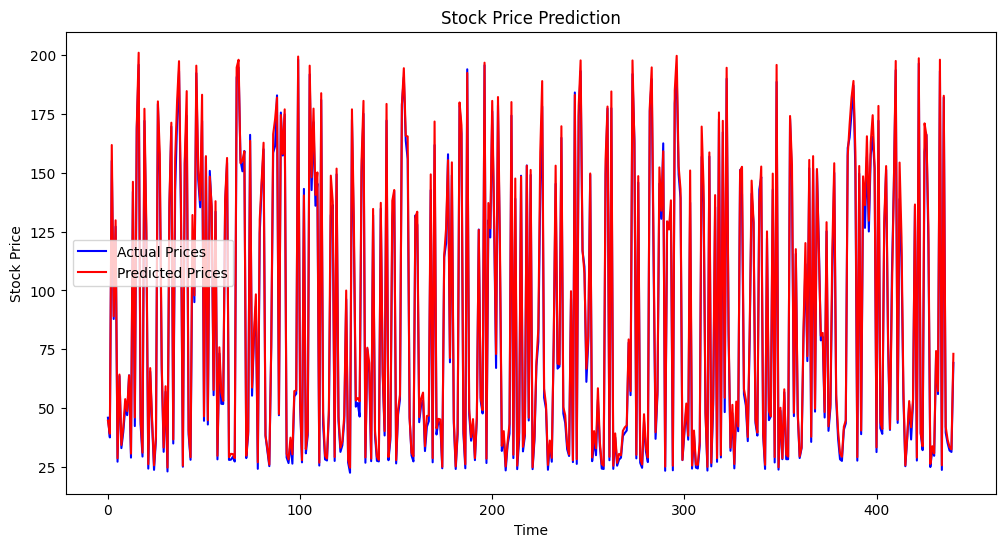

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data[['Close']]  # Focus on closing prices

# Example
ticker = "AAPL"  # Replace with desired ticker
start_date = "2015-01-01"
end_date = "2023-12-31"
data = fetch_stock_data(ticker, start_date, end_date)

def preprocess_data(data, sequence_length):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i, 0])
        y.append(scaled_data[i, 0])

    X = np.array(X)
    y = np.array(y)
    return X, y, scaler

sequence_length = 60  # Sequence length for the GRU
X, y, scaler = preprocess_data(data.values, sequence_length)

# Reshape X for GRU input
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

input_shape = (X.shape[1], 1)
model = build_gru_model(input_shape)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

def predict_and_plot(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(12, 6))
    plt.plot(actual, color='blue', label='Actual Prices')
    plt.plot(predictions, color='red', label='Predicted Prices')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

predict_and_plot(model,X_test,y_test,scaler)

In [2]:
def predict_future_prices(model, last_sequence, days, scaler):
    predictions = []
    current_sequence = last_sequence

    for _ in range(days):
        prediction = model.predict(current_sequence[np.newaxis, :, :])
        predictions.append(prediction[0, 0])
        # Reshape the prediction to (1, 1) before appending
        current_sequence = np.append(current_sequence[1:], prediction.reshape(1,1), axis=0)
        # axis=0 ensures the prediction is appended as a new row

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Predict next 30 days
last_sequence = X[-1]
future_predictions = predict_future_prices(model, last_sequence, 30, scaler)
print(future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━